#Requirements

In [1]:
!pip3 install datasets skorch torchinfo torchdata torchtext torchvision matplotlib portalocker>=2.0.0

In [2]:
!pip3 install torchdata

# Imports

In [3]:
import torch
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings

torch.utils.data.datapipes.utils.common.DILL_AVAILABLE = torch.utils._import_utils.dill_available()
import torchdata
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext i

In [4]:
train, test = IMDB(root="dataset", split=('train', 'test')) # This is a Torch "datapipeline"
train.shuffle()
test.shuffle()
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
# Build validation set
valid, test = test.random_split(total_length=len_test*2, weights={"valid": 0.5, "test": 0.5}, seed=42)
# Get data from the pipeline
train_data = [x for x in train]
test_data = [x for x in test]
val_data = [x for x in valid]

In [5]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [6]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn't go on to star in more and better films. Sadly, I didn't think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat's Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is about a 

Let's check the dataset statistics.

In [7]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{1: 12500, 2: 12500}
val:
{1: 6245, 2: 6255}
test:
{1: 6255, 2: 6245}


In [8]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [9]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [10]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [11]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [12]:
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn't go on to star in more and better films. Sadly, I didn't think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat's Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is about a detect

To keep the length of the all the input sequences same, we define the padding function. All the sentence less than the lenght of 500 will be padded with zeros and greater than 500 will be truncated. Notice that we will pad and truncate sequences right-wise, so that processing the sequences, the final hidden states of the recurrent networks will correspond to the final words of each sequence in the batch.



In [13]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6))
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [14]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [15]:
class CustomDataset(Dataset):

  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [16]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [17]:
batch_size = 128
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

In [20]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers, rnn_dropout,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional

    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'

    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim)

    chosen_rnn = valid_types[self.RNN_type]
    self.rnn = chosen_rnn(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, dropout=rnn_dropout, bidirectional = self.bidirectional)

    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    # x: (batch_size, 500)
    # [TO COMPLETE]

    # Embeds have shape (batch_size, 500, 10)
    embeds = self.embedding(x)

    # But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    # [TO COMPLETE]
    embeds = embeds.permute(1, 0, 2)
    rnn_out, self.last_hidden =  self.rnn(embeds)
    # rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    # h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)

    # hint: pay attention to WHICH output dimension corresponds to the elements of the sequence
    # [TO COMPLETE]
    if self.bidirectional:
        output = self.linear(torch.cat((rnn_out[-1, :, :self.hidden_size], rnn_out[-1, :, self.hidden_size:]), dim=1))
    else:
        output = self.linear(rnn_out[-1, :, :])

      # output: (batch_size, 1)
    output = output.flatten()
      # output: (batch_size)
    return F.sigmoid(output)


In [21]:
'''
CHECK I
'''
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 5
num_layers = 2
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True
#BiDirectional GRU with 2 layers of hidden size of 5

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=0, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

label, text = next(iter(dataloader_training))
x = model.forward(text)
print(x.shape)
print(x[52]) #sigmoid output

torch.Size([128])
tensor(0.5273, device='cuda:0', grad_fn=<SelectBackward0>)


Here, we use the My_RNN class to check the model summary for different models.

In [22]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=0, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

summary(model)
#if you see there is a differnce of 1408-1376=32 with the keras version
#that is because of the fact that keras does not consider bias terms for RNNs.

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─RNN: 1-2                               1,408
├─Linear: 1-3                            33
Total params: 101,441
Trainable params: 101,441
Non-trainable params: 0

In [23]:
criterion = torch.nn.BCELoss()  # does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [24]:
'''
Sanity Check II: Overfitting on one batch
'''
E = 500
label, text = next(iter(dataloader_training))
for itr in range(E):
    model.train()
    optimizer.zero_grad()
    logits = model(text)
    loss = criterion(logits, label)
    if itr % 100 == 0 or itr == E-1:
      print(f"epoch: {itr} -> Loss: {loss}")
    loss.backward()
    optimizer.step()

epoch: 0 -> Loss: 0.7011196613311768
epoch: 100 -> Loss: 0.09846168011426926
epoch: 200 -> Loss: 0.007389295846223831
epoch: 300 -> Loss: 0.004502736032009125
epoch: 400 -> Loss: 0.0027161389589309692
epoch: 499 -> Loss: 0.0018829270265996456


# Simple RNN

We define a Simple RNN model and evaluate its performance. We define the training and evaluation loop. The function takes the model, optimizer, dataloader_train, dataloader_val and epochs as input parameters. The function returns training loss, validation loss, training accuracy and validation accuracy to monitor the model performance.

In [25]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [26]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

In [59]:
emb_dim =  128
hidden_size =  32
num_layers = 2
rnn_dropout =  0.2
lr = 1e-4
RNN_type = 'Simple RNN'

vocab_length = len(vocab)
EPOCHS = 50

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=rnn_dropout, RNN_type='Simple RNN',
               bidirectional=False).to(device)

criterion = torch.nn.BCELoss() #does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [60]:
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         1,280,000
├─RNN: 1-2                               7,296
├─Linear: 1-3                            33
Total params: 1,287,329
Trainable params: 1,287,329
Non-trainable params: 0

In [61]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.16%, Loss: 0.69752872 ---------------- Val_Acc: 52.94%, Val_Loss: 0.69036263
epoch: 2 -> Accuracy: 53.12%, Loss: 0.68994683 ---------------- Val_Acc: 55.30%, Val_Loss: 0.68520427
epoch: 3 -> Accuracy: 55.07%, Loss: 0.68493277 ---------------- Val_Acc: 56.90%, Val_Loss: 0.67928183
epoch: 4 -> Accuracy: 57.12%, Loss: 0.67760140 ---------------- Val_Acc: 58.52%, Val_Loss: 0.66966128
epoch: 5 -> Accuracy: 60.10%, Loss: 0.66240942 ---------------- Val_Acc: 63.25%, Val_Loss: 0.64184290
epoch: 6 -> Accuracy: 65.10%, Loss: 0.62739688 ---------------- Val_Acc: 67.18%, Val_Loss: 0.61248118
epoch: 7 -> Accuracy: 66.78%, Loss: 0.61583644 ---------------- Val_Acc: 66.83%, Val_Loss: 0.61041474
epoch: 8 -> Accuracy: 69.02%, Loss: 0.59530115 ---------------- Val_Acc: 69.61%, Val_Loss: 0.58914989
epoch: 9 -> Accuracy: 68.89%, Loss: 0.59360731 ---------------- Val_Acc: 70.06%, Val_Loss: 0.58068466
epoch: 10 -> Accuracy: 70.55%, Loss: 0.57620883 ---------------- Val_Acc: 70.46%, 

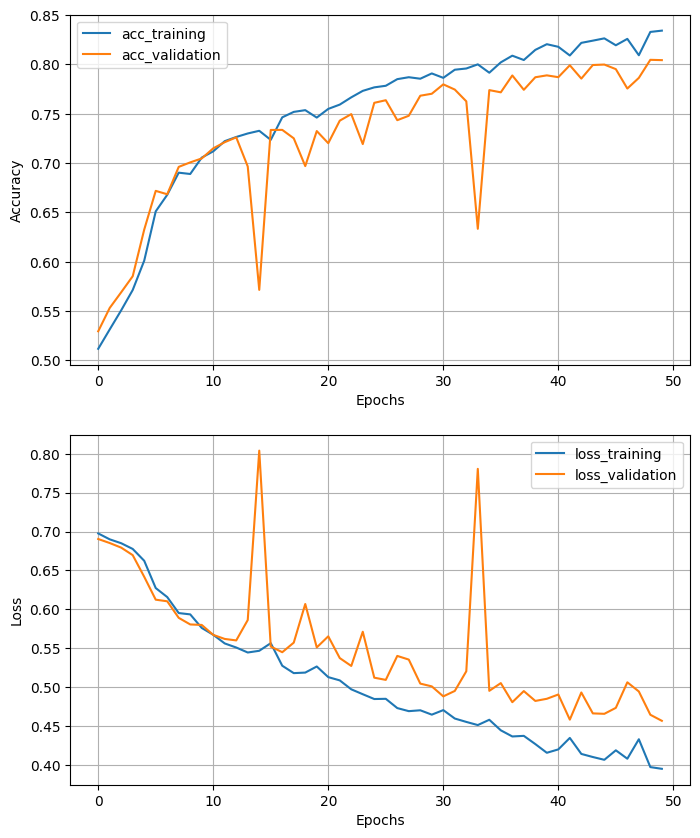

In [62]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [63]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")


In [66]:
test(model)

Test Loss: 0.46369863 ---------- Test Accuracy: 80.1360%


In [67]:
vocab_length = len(vocab)



bidirectional = False
emb_dim =  128
hidden_size =  32
num_layers = 2
rnn_dropout =  0.2
lr = 1e-4
RNN_type = 'GRU' # possible choices -> ['Simple RNN', 'LSTM', 'GRU']


vocab_length = len(vocab)
EPOCHS = 50


model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=rnn_dropout, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = torch.nn.BCELoss()#does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         1,280,000
├─GRU: 1-2                               21,888
├─Linear: 1-3                            33
Total params: 1,301,921
Trainable params: 1,301,921
Non-trainable params: 0

In [68]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 52.73%, Loss: 0.69110739 ---------------- Val_Acc: 55.26%, Val_Loss: 0.68733215
epoch: 2 -> Accuracy: 56.67%, Loss: 0.68287611 ---------------- Val_Acc: 58.11%, Val_Loss: 0.67763060
epoch: 3 -> Accuracy: 60.20%, Loss: 0.66721374 ---------------- Val_Acc: 60.94%, Val_Loss: 0.65805256
epoch: 4 -> Accuracy: 64.16%, Loss: 0.63555932 ---------------- Val_Acc: 66.17%, Val_Loss: 0.61545527
epoch: 5 -> Accuracy: 70.60%, Loss: 0.57068253 ---------------- Val_Acc: 73.09%, Val_Loss: 0.54280430
epoch: 6 -> Accuracy: 74.01%, Loss: 0.53165114 ---------------- Val_Acc: 74.03%, Val_Loss: 0.53617185
epoch: 7 -> Accuracy: 75.96%, Loss: 0.50600833 ---------------- Val_Acc: 75.18%, Val_Loss: 0.51383781
epoch: 8 -> Accuracy: 76.48%, Loss: 0.49741685 ---------------- Val_Acc: 76.10%, Val_Loss: 0.50106305
epoch: 9 -> Accuracy: 78.56%, Loss: 0.47153264 ---------------- Val_Acc: 77.16%, Val_Loss: 0.48612335
epoch: 10 -> Accuracy: 79.40%, Loss: 0.45686233 ---------------- Val_Acc: 76.93%, 

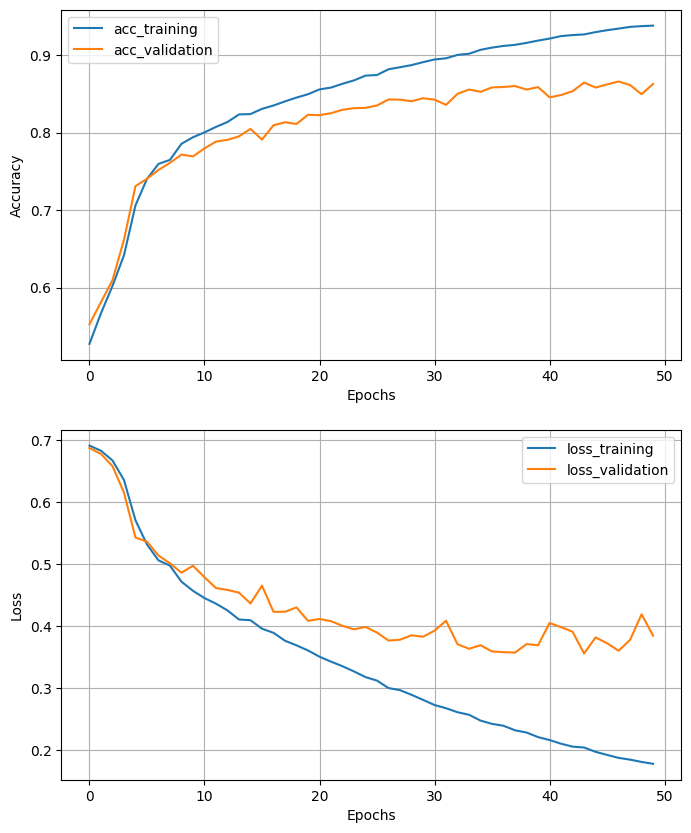

In [69]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [70]:
test(model)

Test Loss: 0.38820499 ---------- Test Accuracy: 86.0960%


In [71]:
vocab_length = len(vocab)



bidirectional = False
emb_dim =  128
hidden_size =  32
num_layers = 2
rnn_dropout =  0.2
lr = 1e-4
RNN_type = 'LSTM' # possible choices -> ['Simple RNN', 'LSTM', 'GRU']


vocab_length = len(vocab)
EPOCHS = 50



model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, rnn_dropout=rnn_dropout, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = torch.nn.BCELoss()#does not apply sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         1,280,000
├─LSTM: 1-2                              29,184
├─Linear: 1-3                            33
Total params: 1,309,217
Trainable params: 1,309,217
Non-trainable params: 0

In [72]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.24%, Loss: 0.69282049 ---------------- Val_Acc: 54.22%, Val_Loss: 0.69043148
epoch: 2 -> Accuracy: 56.84%, Loss: 0.68712294 ---------------- Val_Acc: 58.50%, Val_Loss: 0.68096995
epoch: 3 -> Accuracy: 63.26%, Loss: 0.64885569 ---------------- Val_Acc: 68.74%, Val_Loss: 0.60763180
epoch: 4 -> Accuracy: 69.66%, Loss: 0.59433275 ---------------- Val_Acc: 69.98%, Val_Loss: 0.58591282
epoch: 5 -> Accuracy: 70.64%, Loss: 0.57765740 ---------------- Val_Acc: 71.09%, Val_Loss: 0.58926356
epoch: 6 -> Accuracy: 73.13%, Loss: 0.55363303 ---------------- Val_Acc: 73.14%, Val_Loss: 0.55354178
epoch: 7 -> Accuracy: 69.74%, Loss: 0.57730693 ---------------- Val_Acc: 73.37%, Val_Loss: 0.55069542
epoch: 8 -> Accuracy: 74.68%, Loss: 0.53002506 ---------------- Val_Acc: 74.66%, Val_Loss: 0.53308761
epoch: 9 -> Accuracy: 76.34%, Loss: 0.50794935 ---------------- Val_Acc: 74.65%, Val_Loss: 0.54021919
epoch: 10 -> Accuracy: 75.12%, Loss: 0.51772594 ---------------- Val_Acc: 74.69%, 

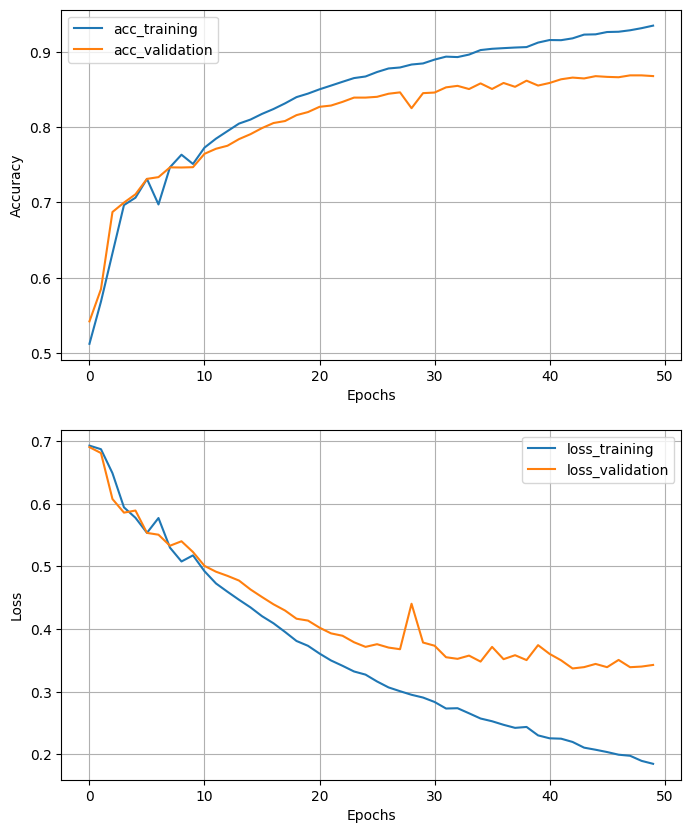

In [73]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [74]:
test(model)

Test Loss: 0.35128689 ---------- Test Accuracy: 86.4640%


### Discussion and Report on Results

#### Hyperparameters and Model Complexity

**Params1**:
- **Embedding Dimension**: 300
- **Hidden Size**: 256
- **Number of Layers**: 3
- **Dropout**: 0.3
- **Learning Rate**: 1e-4

**Params2**:
- **Embedding Dimension**: 128
- **Hidden Size**: 32
- **Number of Layers**: 2
- **Dropout**: 0.2
- **Learning Rate**: 1e-4

### Results Summary

#### Simple RNN
- **Params1**:
  - **Test Accuracy**: 82.3680%
  - **Validation Accuracy**: 83.10%
  - **Training Accuracy**: 95.65%
  - **Validation Loss**: 0.55630934
  - **Test Loss**: 0.56872267
  - **Training Time**: 1471.80s

- **Params2**:
  - **Test Accuracy**: 80.1360%
  - **Validation Accuracy**: 80.43%
  - **Training Accuracy**: 83.42%
  - **Validation Loss**: 0.45697975
  - **Test Loss**: 0.46369863
  - **Training Time**: 705.46s

#### GRU
- **Params1**:
  - **Test Accuracy**: 88.3200%
  - **Validation Accuracy**: 88.90%
  - **Training Accuracy**: 99.96%
  - **Validation Loss**: 0.69494796
  - **Test Loss**: 0.68980563
  - **Training Time**: 1799.17s

- **Params2**:
  - **Test Accuracy**: 86.0960%
  - **Validation Accuracy**: 86.29%
  - **Training Accuracy**: 93.81%
  - **Validation Loss**: 0.38453889
  - **Test Loss**: 0.38820499
  - **Training Time**: 715.04s

#### LSTM
- **Params1**:
  - **Test Accuracy**: 87.6320%
  - **Validation Accuracy**: 88.38%
  - **Training Accuracy**: 99.96%
  - **Validation Loss**: 0.74028105
  - **Test Loss**: 0.79586285
  - **Training Time**: 1817.62s

- **Params2**:
  - **Test Accuracy**: 86.4640%
  - **Validation Accuracy**: 86.78%
  - **Training Accuracy**: 93.48%
  - **Validation Loss**: 0.34285787
  - **Test Loss**: 0.35128689
  - **Training Time**: 728.38s

### Analysis and Observations

1. **Impact of Model Complexity**:
   - For all three architectures, the Params1 configuration resulted in significantly higher training accuracy compared to Params2. This is expected due to the larger embedding dimension, hidden size, and number of layers, which provide the model with more capacity to learn from the training data.
   - However, this increased complexity led to overfitting, as indicated by the substantial drop in validation accuracy compared to training accuracy. For instance, the Simple RNN with Params1 achieved a training accuracy of 95.65% but only a validation accuracy of 83.10%, showing a significant gap.

2. **Regularization and Dropout**:
   - The Params2 configuration, with increased dropout and reduced model size, helped in mitigating overfitting. The validation and test accuracies for Params2 were closer to the training accuracies, indicating better generalization. This is evident in the LSTM model, where the gap between training and validation accuracies reduced significantly with Params2.

3. **Performance of Different Architectures**:
   - GRU and LSTM generally outperformed the Simple RNN in terms of test and validation accuracies. This aligns with the known capabilities of GRU and LSTM to handle long-term dependencies better than Simple RNNs.
   - Among the architectures, GRU consistently provided the best balance of performance and training time. With Params1, GRU achieved a test accuracy of 88.32% and a validation accuracy of 88.90%. With Params2, the GRU model showed a similar trend with improved generalization.

4. **Training Time**:
   - The training time was notably lower for Params2 configurations due to the reduced number of parameters. For example, the Simple RNN with Params2 took 705.46 seconds compared to 1471.80 seconds with Params1.
   - Despite the reduced training time, the Params2 configurations provided competitive test and validation accuracies, demonstrating the efficiency of using simpler models with appropriate regularization.


### Comprehensive Table with Detailed Parameters and Metrics

| Model Name | Hyperparameters Configurations                                   | # Parameters | Training Accuracy | Validation Accuracy | Validation Loss | Test Accuracy | Test Loss   | Training Time |
|------------|------------------------------------------------------------------|--------------|-------------------|---------------------|----------------|---------------|-------------|---------------|
| Simple RNN | emb_dim=300, hidden_size=256, num_layers=3, lr=1e-4, dropout=0.3 | 3,406,273    | 95.65%            | 83.10%              | 0.55630934     | 82.3680%      | 0.56872267  | 1471.80s      |
| GRU        | emb_dim=300, hidden_size=256, num_layers=3, lr=1e-4, dropout=0.3 | 4,218,305    | 99.96%            | 88.90%              | 0.69494796     | 88.3200%      | 0.68980563  | 1799.17s      |
| LSTM       | emb_dim=300, hidden_size=256, num_layers=3, lr=1e-4, dropout=0.3 | 4,624,321    | 99.96%            | 88.38%              | 0.74028105     | 87.6320%      | 0.79586285  | 1817.62s      |
| Simple RNN | emb_dim=128, hidden_size=32, num_layers=2, lr=1e-4, dropout=0.2  | 1,287,329    | 83.42%            | 80.43%              | 0.45697975     | 80.1360%      | 0.46369863  | 705.46s       |
| GRU        | emb_dim=128, hidden_size=32, num_layers=2, lr=1e-4, dropout=0.2  | 1,301,921    | 93.81%            | 86.29%              | 0.38453889     | 86.0960%      | 0.38820499  | 715.04s       |
| LSTM       | emb_dim=128, hidden_size=32, num_layers=2, lr=1e-4, dropout=0.2  | 1,309,217    | 93.48%            | 86.78%              | 0.34285787     | 86.4640%      | 0.35128689  | 728.38s       |



`%ENDCODE%`

# Explore relations between words

In [75]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [76]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

#w1, w2, w3 = 'man', 'woman', 'doctor'
#w4_cand = ['doctor', 'dentist', 'nurse', 'illness']
#w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
#print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between king -> prophet
The relation between germany -> berlin is like the realtion between italy -> france


# Transformer 

In [77]:
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)

batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [78]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    #d_model (int) – the number of expected features in the encoder/decoder inputs (default=512).
    #nhead (int) – the number of heads in the multiheadattention models (default=8).
    #num_encoder_layers (int) – the number of sub-encoder-layers in the encoder (default=6).
    #num_decoder_layers (int) – the number of sub-decoder-layers in the decoder (default=6).
    #dim_feedforward (int) – the dimension of the feedforward network model (default=2048).
    #dropout (float) – the dropout value (default=0.1).
    #layer_norm_eps (float) – the eps value in layer normalization components (default=1e-5).
    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)

    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''

    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long())
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

In [79]:
'''
Transformer Check
'''
lb, txt = next(iter(dataloader_training_trns))
trns = My_Transform(5, 1, 1, 1, 2, 1e-5, 0.2).to(device)
#####################
gc.collect()
#####################
out = trns.forward(txt, lb)
assert out.shape == lb.shape, "Ops, something is wrong!"
print(out.shape)

torch.Size([256])


In [80]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [94]:
d_model = 64  # Reduced model dimension
nhead = 8  # Reduced number of attention heads
num_encoder_layers = 8  # Reduced number of encoder layers
num_decoder_layers = 8  # Reduced number of decoder layers
dim_feedforward =64   # Reduced dimension of feedforward network
dropout = 0.2  # Increased dropout to prevent overfitting
lr = 1e-4  # Increased learning rate to speed up convergence

layer_norm_eps = 1e-5
EPOCHS = 50

transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss() #does not apply sigmoid
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       640,000
├─Embedding: 1-2                                                       128
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            201,728
│    │    └─LayerNorm: 3-2                                             128
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            335,872
│    │    └─LayerNorm: 3-4                                             128
├─Linear: 1-4                                                          65
Total params: 1,178,049
Trainable params: 1,178,049
Non-trainable params: 0

In [95]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 50.82%, Loss: 0.70606828 ---------------- Val_Acc: 57.06%, Val_Loss: 0.67353243
epoch: 2 -> Accuracy: 59.41%, Loss: 0.66499406 ---------------- Val_Acc: 66.40%, Val_Loss: 0.62033802
epoch: 3 -> Accuracy: 66.31%, Loss: 0.61541724 ---------------- Val_Acc: 70.26%, Val_Loss: 0.59238130
epoch: 4 -> Accuracy: 69.77%, Loss: 0.57804161 ---------------- Val_Acc: 72.40%, Val_Loss: 0.55908692
epoch: 5 -> Accuracy: 72.07%, Loss: 0.55149275 ---------------- Val_Acc: 73.98%, Val_Loss: 0.53680229
epoch: 6 -> Accuracy: 73.52%, Loss: 0.53126663 ---------------- Val_Acc: 75.10%, Val_Loss: 0.52325201
epoch: 7 -> Accuracy: 75.19%, Loss: 0.51077837 ---------------- Val_Acc: 76.21%, Val_Loss: 0.50455827
epoch: 8 -> Accuracy: 76.27%, Loss: 0.49330699 ---------------- Val_Acc: 77.18%, Val_Loss: 0.51107776
epoch: 9 -> Accuracy: 77.04%, Loss: 0.47630656 ---------------- Val_Acc: 77.71%, Val_Loss: 0.48670161
epoch: 10 -> Accuracy: 78.54%, Loss: 0.45579529 ---------------- Val_Acc: 79.32%, 

KeyboardInterrupt: 

Due to deadline, I stopped training because it would pass the deadline.

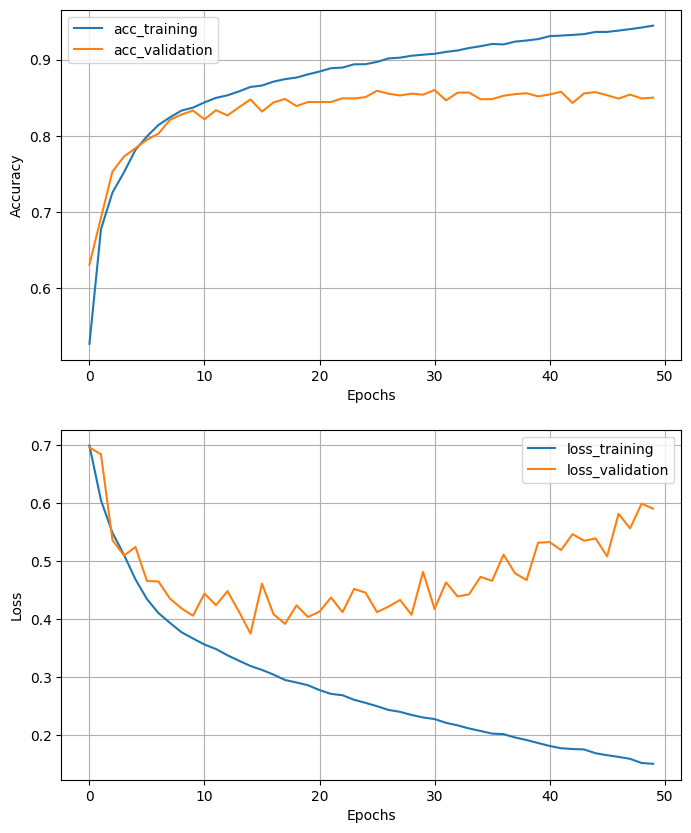

In [96]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [97]:
@torch.no_grad()
def test_trns(model, dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text, label)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [98]:
test_trns(transformer, dataloader_test_trns)

Test Loss: 0.39509356 ---------- Test Accuracy: 84.6720%
